개인적으로 무의미하다 판단했던 데이터에 대해서 따로 사용을 하신 방향이 있는지?  
Y 결측치에 대해서 어떻게 처리를 했는지?  
현재 Y결측치 dropna로 날리고 해서 날라가는 데이터들이 너무 아까움.  
(selftrainingclassifier 셀프트레이닝이 있더라)  
https://machinelearningmastery.com/semi-supervised-learning-with-label-propagation/
https://scikit-learn.org/stable/modules/semi_supervised.html

In [ ]:
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.info()

In [ ]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 값이 무의미 "Cancelled", "Diverted"
#  _ID로 대체가능 "Origin_Airport", "Destination_Airport" "Origin_State", "Destination_State", "Airline"
# IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음 So, 제거 Carrier_Code(IATA)
train = train.drop(["ID","Cancelled", "Diverted", "Origin_Airport", "Destination_Airport", "Origin_State", "Destination_State", "Airline", "Carrier_Code(IATA)"], axis=1)
test = test.drop(["ID","Cancelled", "Diverted", "Origin_Airport", "Destination_Airport", "Origin_State", "Destination_State", "Airline", "Carrier_Code(IATA)"], axis=1)

# Month 출발일, Day_of_Month 출발날짜 
# Origin_Airport_ID 출발 항공사 ID, Destination_Airport 도착 항공사 ID
# Distance  mile 거리, Tail_Number 항공기의 고유 등록번호, Delay
# Estimated_Departure_Time 출발시간, Estimated_Arrival_Time 도착시간 // 결측치 존재
# Carrier_ID(DOT) 항공사 고유 ID 결측치 존재
# Delay 결측치 존재

#출발도착 둘 다 널, 고유ID 최빈값으로 넣음
train['Carrier_ID(DOT)'] = train['Carrier_ID(DOT)'].fillna(train['Carrier_ID(DOT)'].mode()[0])
train.loc[ train['Estimated_Departure_Time'].isnull()&train['Estimated_Arrival_Time'].isnull(), ['Estimated_Departure_Time']] = train['Estimated_Departure_Time'].mode()[0]

test['Carrier_ID(DOT)'] = test['Carrier_ID(DOT)'].fillna(test['Carrier_ID(DOT)'].mode()[0])
test.loc[ test['Estimated_Departure_Time'].isnull()&test['Estimated_Arrival_Time'].isnull(), ['Estimated_Departure_Time']] = test['Estimated_Departure_Time'].mode()[0]

def to_minutes(row):
  try:
    row = int(row)
    row = str(row)
    if len(row) > 2:
      return int(row[:-2])*60 + int(row[-2:])
    else:
      return int(row[-2:])
  except:
    return np.nan

train['Estimated_Departure_Time'] = train['Estimated_Departure_Time'].apply(to_minutes)
train['Estimated_Arrival_Time'] = train['Estimated_Arrival_Time'].apply(to_minutes)

test['Estimated_Departure_Time'] = test['Estimated_Departure_Time'].apply(to_minutes)
test['Estimated_Arrival_Time'] = test['Estimated_Arrival_Time'].apply(to_minutes)

# apply가 왜 안돼
# 7.767
# 출발 도착으로 운행시간을 만들자.
# 거리합/(도착합-출발합) = 평균 분당 거리로 가정 7.767
# 출발 is null then 도착 - 거리/시간
# 도착 is null then 출발 + 거리/시간
for i, r in train.iterrows():
  if(pd.isnull(train['Estimated_Departure_Time'][i])):
    train['Estimated_Departure_Time'][i] = train['Estimated_Arrival_Time'][i] - (train['Distance'][i]/7.767)
  elif(pd.isnull(train['Estimated_Arrival_Time'][i])):
    train['Estimated_Arrival_Time'][i] = int(train['Estimated_Departure_Time'][i] + train['Distance'][i]/7.767)

for i, r in test.iterrows():
  if(pd.isnull(test['Estimated_Departure_Time'][i])):
    test['Estimated_Departure_Time'][i] = test['Estimated_Arrival_Time'][i] - (test['Distance'][i]/7.767)
  elif(pd.isnull(train['Estimated_Arrival_Time'][i])):
    test['Estimated_Arrival_Time'][i] = int(test['Estimated_Departure_Time'][i] + test['Distance'][i]/7.767)

# ------ 결측치 제거 완료
train['Delay'].map(lambda x : 0 if x=="Not_Delayed" else 1)
train = train.dropna(subset=['Delay'], how='any')

# OrdinalEncoder로 시도했으나 에러 해결 못함.
#categorical[Tail_Number""]
#from sklearn.preprocessing import OrdinalEncoder
#oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan).fit(train[categorical])
#train_enc = pd.DataFrame( oe.transform(train[categorical]), index=train.index)
#test_enc = pd.DataFrame( oe.transform(test[categorical]), index=test.index )

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Tail_Number'].astype(str))
train['Tail_Number'] = le.transform(train['Tail_Number'].astype(str))

prev_class = list(le.classes_)

for label in np.unique(test['Tail_Number'].astype(str)):
  if label not in prev_class:
    prev_class.append(label)

le.classes_ = np.array(prev_class)
test['Tail_Number'] = le.transform(test['Tail_Number'].astype(str))

train = train.dropna(subset=['Delay'], how='any')
train = train.reset_index(drop=True)
train['Delay'] = train['Delay'].map(lambda x : 0 if x=="Not_Delayed" else 1)

y_train = train.Delay
x_train = train.drop(['Delay'], axis=1);

In [ ]:
#공유하고싶은 내용

import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

X = x_train
y = y_train

#다양한 분류모형 비교
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

MLA = [
    #Tree, Ensemble Methods
    tree.DecisionTreeClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
    ensemble.AdaBoostClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Nearest Neighbor
    KNeighborsClassifier()]

In [ ]:
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit

#train_test_split보다 편하게 여러개 생성 가능 (10개를 만들거임 60:30으로 10은 뺴두기)
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#MLA 비교
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(y)

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #CV score: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X, y, cv  = cv_split,return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    #save MLA predictions
    alg.fit(X, y)
    MLA_predict[MLA_name] = alg.predict(X)
    row_index+=1
 

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

#결과가 LGBMClassifier이 좋다고 나왔다.

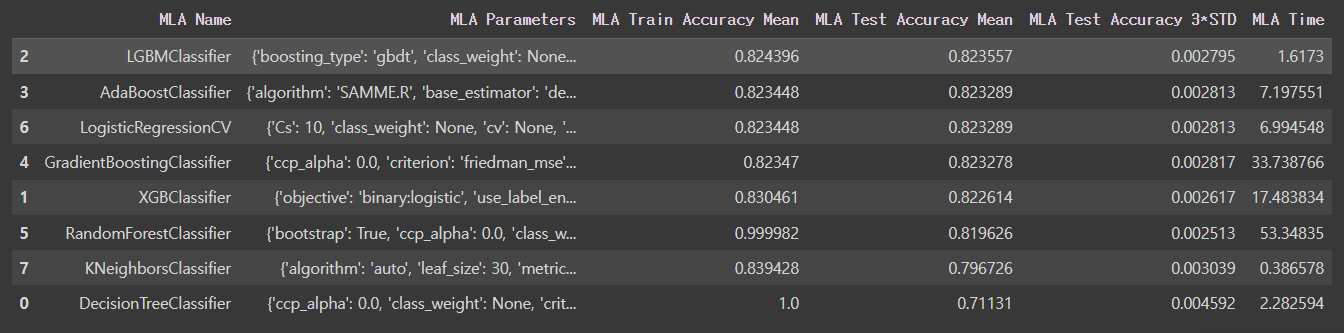

In [ ]:
#!pip install optuna
# optuna로 optimaze할 수 있으면 해서 파라메타 구한 후에 그걸로 fit하면 더 좋은 결과 가능
# 아래에 예시 작성했음.

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn import datasets
from sklearn.metrics import make_scorer, accuracy_score
from functools import partial

def objective(X, y, trial):
    params = {
        'booster':trial.suggest_categorical('booster', ['gbtree', 'dart', 'gblinear']),
        'learning_rate':trial.suggest_uniform("learning_rate", 0.01, 0.02),
        'max_depth':trial.suggest_int("max_depth", 2, 4)
            }

    model = LGBMClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=2, scoring=make_scorer(accuracy_score))

    return 1 - score.mean()

f = partial(objective, x_train, y_train)

study = optuna.create_study()
study.optimize(f, n_trials=100) #n_trials이 반복 횟수

model = LGBMClassifier(**study.best_params)
model.fit(x_train, y_train)
y_pred = model.predict(test)
print("best_trial - ", study.best_trial)

In [ ]:
from lightgbm import LGBMClassifier
lgbModel = LGBMClassifier(booster = 'gbtree', learning_rate = 0.01401744797513704, max_depth = 3)
lgbModel.fit(x_train, y_train)
lgb_pred = lgbModel.predict_proba(test)

print(lgbModel.score(x_train, y_train))
print("lgb_pred - ", lgb_pred)

[LightGBM] [Warning] Unknown parameter: booster
0.8235301038035145
lgb_pred -  [[0.79956328 0.20043672]
 [0.81749419 0.18250581]
 [0.77952898 0.22047102]
 ...
 [0.75244197 0.24755803]
 [0.82020146 0.17979854]
 [0.84196836 0.15803164]]


In [ ]:
#전처리까지는 끝냈는데 이걸 어떻게 적용시키는지를 모르겠어서 제출을 못함
import pandas as pd
submit = pd.read_csv("sample_submission.csv")

submission = pd.DataFrame(data=lgb_pred, columns=submit.columns, index=submit.index)
submission